# Image captioning model - Tune
Following guide from [HuggingFace: Image captioning](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning)

## Libraries & packages

In [6]:
#!pip install transformers datasets evaluate -q
#!pip install jiwer -q
#!pip install transformers[torch]
#!pip install -U accelerate
#!pip install bitsandbytes

##  Import dataset
Generate a {image-caption} pairs metadata file in JSON format for the model.

In [1]:
# Path to folder with images
img_path = '../Datasets/childrens-books'

# Path to file with images' description
# Original is CSV format
img_path_csv = '../Manual Image captioning/childrens-books-captions-unicode.csv'
# Generated JSON file path
img_path_json = img_path + '/metadata.jsonl'

In [2]:
import csv
import json

# Function to convert a CSV to JSON
# Takes the file paths as arguments
def make_json(csvFilePath, jsonFilePath):
     
    # create a list
    data = []
     
    # Open a csv reader called DictReader
    with open(csvFilePath) as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Add each row to data list as dictionary
        for row in csvReader:
            data.append(row)
 
    # Open a json writer, and use the json.dumps()
    # function to dump data
    with open(jsonFilePath, 'w') as jsonf:
        for item in data:
            jsonf.write(json.dumps(item) + "\n")

In [3]:
# Call the make_json function
# Saves the json file from csv original file
make_json(img_path_csv, img_path_json)

In [4]:
from datasets import load_dataset
# Load dataset
img_ds = load_dataset('imagefolder', data_dir = img_path)
# Print image dataset info to confirm it was correctly created
img_ds

Resolving data files:   0%|          | 0/1711 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/caprattr/.cache/huggingface/datasets/imagefolder/default-01ec1726dfc20616/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1710
    })
})

## Split dataset into train & test sets
Split dataset into train and test, test size of 25% of total images.

In [5]:
# Split dataset into train and test, test size of 25% of total images
img_ds_split = img_ds['train'].train_test_split(test_size=0.25, shuffle=False)
train_ds = img_ds_split['train']
test_ds = img_ds_split['test']

In [54]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 1282
})

In [55]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 428
})

In [6]:
from textwrap import wrap
import matplotlib.pyplot as plt
from PIL import Image

# Function to plot images
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis('off')

In [49]:
[i for i, string in enumerate(train_ds['text']) if 'Turtles' in string]

[101]

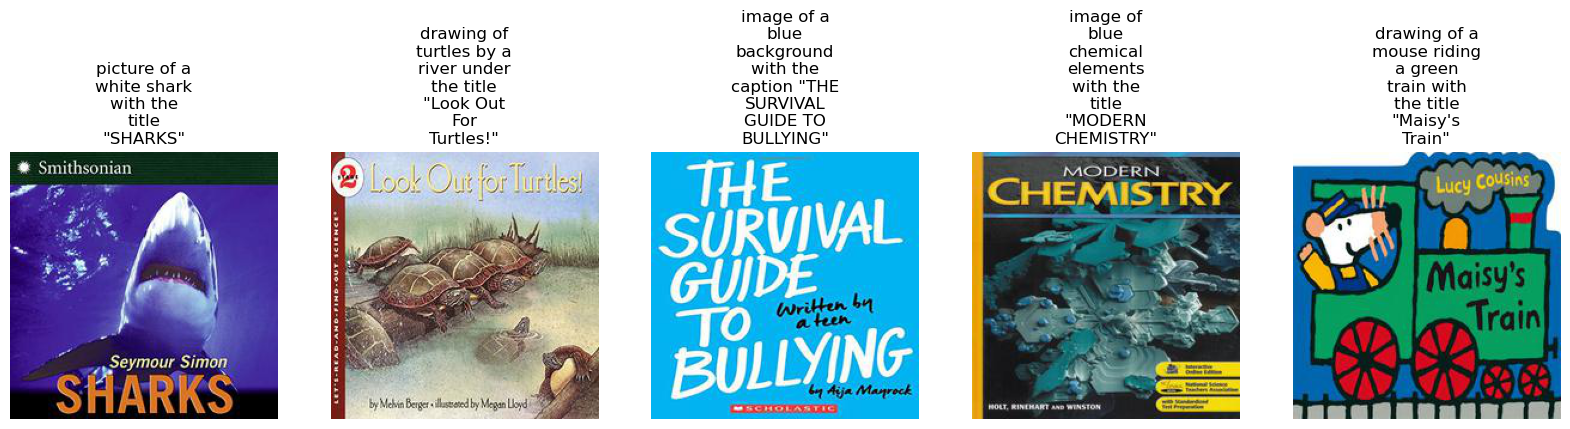

In [53]:
import numpy as np
# Print some images from train dataset
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in [31,101,519,4,795]]
sample_captions = [train_ds[i]["text"] for i in [31,101,519,4,795]]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess dataset
Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

In [23]:
from transformers import AutoProcessor
# Load the processor class associated with the model we are about to fine-tune
checkpoint = 'microsoft/git-large-r-coco'
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [24]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [25]:
# Process datasets
train_ds_proc = ImageCaptioningDataset(train_ds, processor)
test_ds_proc = ImageCaptioningDataset(test_ds, processor)

In [26]:
from torch.utils.data import DataLoader
# Generate dataloaders for datasets
train_dataloader = DataLoader(train_ds_proc, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(test_ds_proc, batch_size=16)

## Load a base model
Load the “microsoft/git-large-r-coco” into a AutoModelForCausalLM object.

In [27]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(checkpoint)

If num_beams is specified the training will use beam search instead of greedy search.

In [47]:
# set number of beams for beam search to 4
num_beams = 4
model.config.num_beams = num_beams

In [33]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(257, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-23): 24 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
      

Evaluate base model with WER metric.

In [29]:
# Function to evaluate model
def evaluate_model(model):
    import evaluate
    from tqdm.auto import tqdm

    progress_bar = tqdm(range(len(eval_dataloader)))

    metric = evaluate.load('wer')
    model.eval()
    for batch in eval_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        with torch.no_grad():
            #generated_ids = model.generate(pixel_values=pixel_values, max_length=50) # greedy search
            generated_ids = model.generate(pixel_values=pixel_values) # beam search

        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        original_caption = processor.batch_decode(input_ids, skip_special_tokens=True)
        metric.add_batch(predictions=generated_caption,references=original_caption)

        progress_bar.update(1)

    print('WER:',metric.compute())

In [54]:
evaluate_model(model)

  0%|          | 0/27 [00:00<?, ?it/s]

WER: 0.8394302848575712


Let's print some generated captions with the base model (WER 0.8394) for test images.

In [34]:
from PIL import Image

# Function to generate caption
def generate_caption(img_path):
    image = Image.open(img_path)
    
    # prepare image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return image, generated_caption

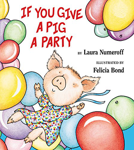

if you give a pig a party


In [36]:
img_root_path = '../Datasets/childrens-books-test/'
image, generated_caption = generate_caption(img_root_path + '0060283262.jpg')
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))
print(generated_caption)

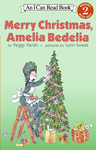

a merry christmas, elizabethan bedtime bedtime story ( children's book )


In [58]:
image, generated_caption = generate_caption(img_root_path + '0060099453.jpg')
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))
print(generated_caption)

## Train model

Define optimizer for model training

In [35]:
import torch
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Create the default learning rate scheduler

In [36]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Specify device to use a GPU if you have access to one. Otherwise, training on a CPU may take several hours instead of a couple of minutes.

**Train the model**

To keep track of training progress, use the tqdm library to add a progress bar over the number of training steps.

In [ ]:
from tqdm.auto import tqdm
# Define progress bar
progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids,
                        attention_mask=attention_mask)
        loss = outputs.loss
        loss.backward()
        
        print("Loss:",loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [29]:
# Save model
torch.save(model.state_dict(), 'childrensimages-caption-20231109')

## Evaluate model

In [59]:
import torch
# Load the pre-trained model
checkpoint = 'childrensimages-caption-20231109'
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(257, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-23): 24 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
      

In [61]:
evaluate_model(model)

  0%|          | 0/27 [00:00<?, ?it/s]

WER: 0.3542728635682159


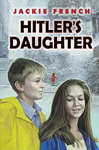

drawing of a boy and a girl with the title " nazi's daughter "


In [64]:
img_root_path = '../Datasets/childrens-books-test/'
image, generated_caption = generate_caption(img_root_path + '0060086521.jpg')
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))
print(generated_caption)

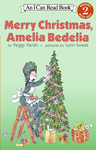

drawing of a girl decorating a christmas tree with the captions " merry little islands, ameliaia "


In [65]:
image, generated_caption = generate_caption(img_root_path + '0060099453.jpg')
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))
print(generated_caption)

## Share model to Hugging Face

In [30]:
from huggingface_hub import notebook_login
notebook_login()

In [31]:
model.push_to_hub('childrensimages-caption-20231109')

pytorch_model.bin:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/CassPR/childrensimages-caption-20231109/commit/74f8b0bf7949b3701c5bdafbe2e32de2d984bf4b', commit_message='Upload GitForCausalLM', commit_description='', oid='74f8b0bf7949b3701c5bdafbe2e32de2d984bf4b', pr_url=None, pr_revision=None, pr_num=None)